# basic set up

In [1]:
#basic set up
%matplotlib inline
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb
from utils.common_imports import *


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [2]:

# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict



def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## execute function

In [19]:
# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    '''
    Parameters
    ==========
    two_stage (boolean): whether to do two stage assignment or not
    
    Returns
    =======
    '''
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        return 0.1*dist

    # refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    if gurobiOptions is None:
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                            heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                # Select the targets
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    #clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes

## write pfsDesign file

In [3]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## plot_filter_fov function

In [4]:

# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [24]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## set bench

In [34]:
# TODO: check with project office if the following function is correct
from pathlib import Path
def create_bench(layout="full"):
    '''
    set bench using different methods

    using CollisionSimulator2 for trajectory collision check when layout is not "full"
    '''
    cobra_coach_dir = "./cobra_coach_temp/"
    fiberids_path = "./pfs_utils-w.2024.45/data/fiberids/"
    pfs_black_dots_path = "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"
    
    pfs_pfi_module_path = Path("./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL_final.xml")

    spectrograph_modules = [1, 2, 3, 4]

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")

    pfs_instdata_path = "./pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path

    # create the grand fiber map
    def create_grand_fiber_map(fiberids_path):
        fibermap = FiberIds(path=fiberids_path)
        return fibermap

    if layout == "full":
        '''
        use CollisionSimulator (not CollisionSimulator2) when layout is "full"
        '''
        bench = Bench(layout="full")
        cobracoach = None
    elif layout == "calibration_ga":
        '''
        use the same code as in GA github repository, i.e.,
        _create_configured_bench() https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)
        calibrationProduct = cobracoach.calibModel

        # Set some dummy center positions and phi angles for those cobras that have
        # zero centers
        zeroCenters = calibrationProduct.centers == 0
        calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
        calibrationProduct.phiIn[zeroCenters] = -np.pi
        calibrationProduct.phiOut[zeroCenters] = 0
        print("Cobras with zero centers: %i" % np.sum(zeroCenters))

        # Use the median value link lengths in those cobras with zero link lengths
        zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
        calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
        calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
        print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

        # Limit spectral modules
        gfm = create_grand_fiber_map(fiberids_path)
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        
    elif layout == "calibration_cobrascalibrationproduct":
        '''
        use CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml") 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)

        bench = Bench(
            layout="calibration", 
            calibrationProduct=CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml"),
            blackDotsCalibrationProduct=BlackDotsCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv")
        )

    elif layout == "calibration_pfi_module":
        '''
        use ALL_final.xml 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(file=pfs_pfi_module_path)
        calibrationProduct = cobracoach.calibModel

        '''
        # Limit spectral modules
        gfm = create_grand_fiber_map(fiberids_path)
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
        '''
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        

    return bench, cobracoach

# main function

## construct tgt list and read pointing centers

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv
In total, there are 1656943 targets.


2025-01-13 12:04:54.094Z matplotlib.font_manager 10 font_manager.py:1378 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-01-13 12:04:54.095Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-13 12:04:54.095Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-13 12:04:54.096Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib

Time passed - construct target list: 35.91 secs
There are 12 pointings.
  Your sample (gray), with the pointings (red):


2025-01-13 12:04:54.356Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.359Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSundanese-Regular.ttf', name='Noto Sans Sundanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.360Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/opt/X11/share/fonts/OTF/SyrCOMNisibinOutline.otf', name='Estrangelo Nisibin Outline', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.361Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntSmBol

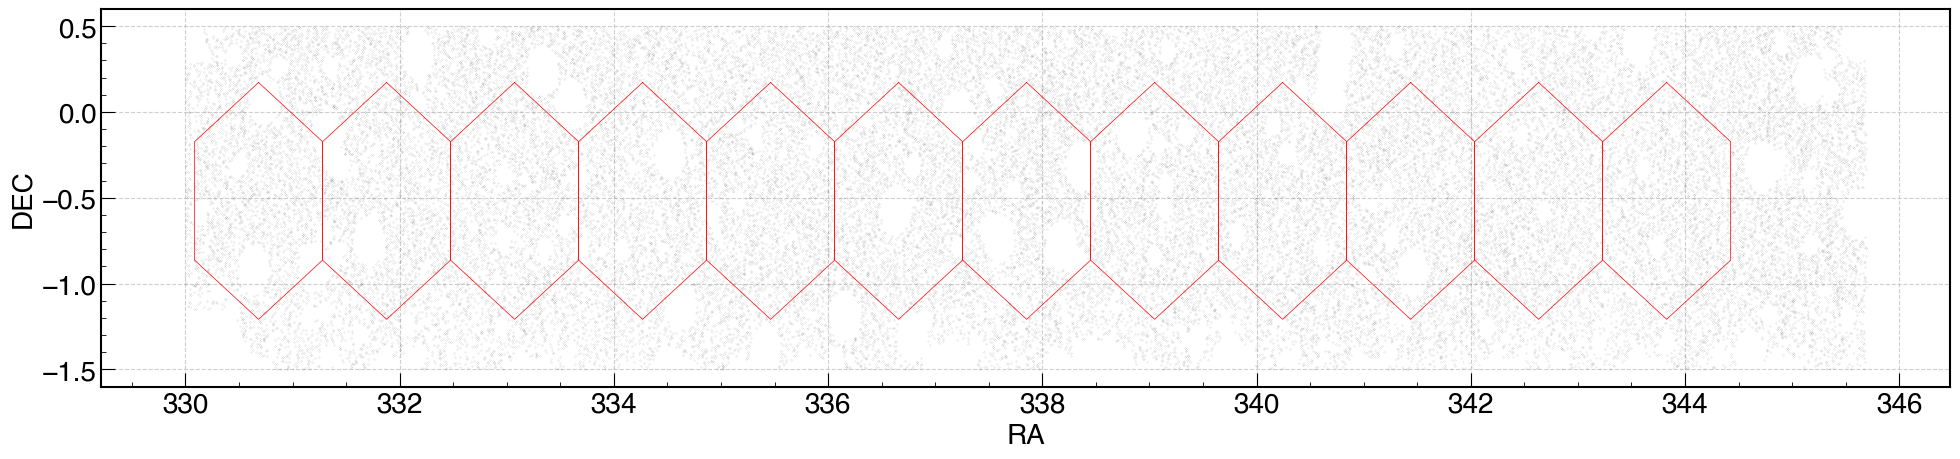

Time passed - read pointings and plot for a small region: 2.52 secs


In [7]:
# TODO: revise the two-stage code structure
two_stage = True
outdir = "../output/test/"
    
t0 = time.time()
########################
#cosmology + sky + star targets
fn_list = ["cosmology_region3_3h_targets.ecsv", "star_region3_3h_targets.ecsv", "sky_region3_3h_targets.ecsv"]
prefix_list = ["sci", "cal", "sky"]
calibration_list = [False, True, True]
    
tgt_s0, sample_sci = construct_tgt_list(catalog_path = "../data_proc/test/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
'''
# TODO: prepare ancillary science targets (smaller size sample)
#anxillary science targets
fn_list = ["anc_select.ecsv", ]
prefix_list = ["anc", ]
calibration_list = [False, ]
    
tgt_s1, sample_sci_s1 = construct_tgt_list(catalog_path = "../data_proc/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
'''

#total targets
#tgt = tgt_s0 + tgt_s1
tgt = tgt_s0
    
n_sci = sample_sci.shape[0]
ra_sci = sample_sci[:, 1].astype('float')
dec_sci = sample_sci[:, 2].astype('float')

t1 = time.time()
print("Time passed - construct target list: %.2f secs" % (t1-t0))

#set the range for getting pointing centers
ra_min, ra_max, dec_min, dec_max = 330, 345, -1.5, 0.5

# read the pointing centers from the file
ra_peaks, dec_peaks = read_pointings("../output/cosmology_region3_pointings.txt")

# select peaks within the range
mask_peaks = (ra_peaks>ra_min) & (ra_peaks<ra_max) & (dec_peaks>dec_min) & (dec_peaks<dec_max)
peaks = np.array([ra_peaks[mask_peaks], dec_peaks[mask_peaks]]).T
npoint = peaks.shape[0]
print("There are %d pointings." % npoint)
    
# plot the pointing and samples
plt.figure(figsize=(20, 5))
print("  Your sample (gray), with the pointings (red):")
fov_diag = 1.38/2. # deg, here it's radius
mask_sci = (ra_sci>ra_min-fov_diag) & (ra_sci<ra_max+fov_diag) & (dec_sci>dec_min-fov_diag) & (dec_sci<dec_max+fov_diag)
plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
    flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=0, n_sci_fov_least=4000, filter_fov=True)

plt.xlabel('RA', fontsize=20)
plt.ylabel('DEC', fontsize=20)
plt.savefig(outdir + 'cosmology_region3_test_fov_plot.png')
plt.show()
plt.close()
    
t2 = time.time()
print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))

## other setting

In [17]:
tele_params = {"otime":"2025-08-20T11:00:00Z", "posang":0.}
gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)


########################
classdict = def_classdict()

########################
# one visit -- can be 1st or 2nd visit
# TODO: set the alreadyObserved dictionary using the alreadyObserved column in the target list
alreadyObserved={}
for t in tgt:
    alreadyObserved[t.ID] = 0

# set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
# TODO: use CobraGroup to get a uniform distribution for calibration targets
for t in tgt:
    if t.targetclass[:3] == 'sci': t.stage = 1

## run_main function

In [25]:
#if __name__ == "__main__":
# main run
def run_main(peaks, tgt, classdict, alreadyObserved, two_stage=True, collision_sim_version=2, bench=None, cobracoach=None, gurobiOptions=None, tele_params=None):
    '''
    test for one pointing
    '''
    outfn_list = []
    for peak in peaks[:1]:
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = 'cosmology_region3_3h_output_v1_ra%.2f_dec%.2f.txt'%(peak[0], peak[1])
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+'cosmology_region3_3h_v1_ra%.2f_dec%.2f.jpg'%(peak[0], peak[1]), Save=True, fn_fibeff=outdir+'cosmology_region3_3h_fibeff_v1.txt')
        
        # output the completeness and fiber assignment fraction
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + 'cosmology_region3_3h_v1_ra%.2f_dec%.2f.csv'%(peak[0], peak[1]), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        for t in tgt_id_done:
            if(t[:3]=='sci'): alreadyObserved[str(t)] = 1

    print("%f secs passed after the visits done." % (time.time()-t0))

    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1.jpg', figsize=(6, 5))
    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1_gray.jpg', figsize=(6, 5), plot_diffcolor=False)

# test bench setting

## full + CollisionSimulator

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:32:21.228Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:32:21.232Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:32:21.234Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:32:21.235Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-13 12:32:21.449Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-13 12:32:21.457Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-13 12:32:21.459Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-13 12:32:21.461Z root             20 DistortionCoefficients.py:715 Ra Dec 

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:32:22.192Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:32:22.196Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:32:22.199Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:32:22.202Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:32:22.205Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:33.068Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:33.073Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:32:33.078Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:33.087Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:33.090Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:32:33.098Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 128835 rows, 67221 columns and 333358 nonzeros


2025-01-13 12:32:33.101Z gurobipy         20 netflow.py:149 Optimize a model with 128835 rows, 67221 columns and 333358 nonzeros


Model fingerprint: 0x88f24c33


2025-01-13 12:32:33.111Z gurobipy         20 netflow.py:149 Model fingerprint: 0x88f24c33


Variable types: 1 continuous, 67220 integer (67218 binary)


2025-01-13 12:32:33.115Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 67220 integer (67218 binary)


Coefficient statistics:


2025-01-13 12:32:33.124Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:32:33.127Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-01, 1e+06]


2025-01-13 12:32:33.129Z gurobipy         20 netflow.py:149   Objective range  [2e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:32:33.133Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:32:33.137Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:32:33.156Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 127927 rows and 64113 columns


2025-01-13 12:32:33.984Z gurobipy         20 netflow.py:149 Presolve removed 127927 rows and 64113 columns


Presolve time: 0.81s


2025-01-13 12:32:33.989Z gurobipy         20 netflow.py:149 Presolve time: 0.81s


Presolved: 908 rows, 3108 columns, 5177 nonzeros


2025-01-13 12:32:34.002Z gurobipy         20 netflow.py:149 Presolved: 908 rows, 3108 columns, 5177 nonzeros


Variable types: 0 continuous, 3108 integer (3106 binary)


2025-01-13 12:32:34.017Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3108 integer (3106 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:32:34.025Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:32:34.037Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:32:34.040Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:32:34.045Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:32:34.051Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:32:34.056Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:32:34.060Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:32:34.064Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:32:34.067Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.955e+03


2025-01-13 12:32:34.122Z gurobipy         20 netflow.py:149  AA' NZ     : 1.955e+03


 Factor NZ  : 4.512e+03 (roughly 2 MB of memory)


2025-01-13 12:32:34.126Z gurobipy         20 netflow.py:149  Factor NZ  : 4.512e+03 (roughly 2 MB of memory)


 Factor Ops : 3.367e+04 (less than 1 second per iteration)


2025-01-13 12:32:34.129Z gurobipy         20 netflow.py:149  Factor Ops : 3.367e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:32:34.133Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:32:34.137Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:32:34.141Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:32:34.144Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.65859257e+08 -2.35641474e+09  2.97e+01 2.74e+04  2.88e+07     1s


2025-01-13 12:32:34.147Z gurobipy         20 netflow.py:149    0   3.65859257e+08 -2.35641474e+09  2.97e+01 2.74e+04  2.88e+07     1s


2025-01-13 12:32:34.153Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.06 seconds (0.34 work units)


2025-01-13 12:32:34.157Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.06 seconds (0.34 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:32:34.161Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:32:34.164Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:32:34.168Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:32:34.172Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:32:34.176Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:32:34.183Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.310828e+02, 86 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:32:34.189Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.310828e+02, 86 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:32:34.255Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:32:34.259Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:32:34.263Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:32:34.266Z gurobipy         20 netflow.py:149 


*    0     0               0     131.0828273  131.08283  0.00%     -    1s


2025-01-13 12:32:34.268Z gurobipy         20 netflow.py:149 *    0     0               0     131.0828273  131.08283  0.00%     -    1s


2025-01-13 12:32:34.292Z gurobipy         20 netflow.py:149 


Explored 1 nodes (86 simplex iterations) in 1.20 seconds (0.34 work units)


2025-01-13 12:32:34.294Z gurobipy         20 netflow.py:149 Explored 1 nodes (86 simplex iterations) in 1.20 seconds (0.34 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:32:34.296Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:32:34.299Z gurobipy         20 netflow.py:149 


Solution count 3: 131.083 5.98e+08 6e+08 


2025-01-13 12:32:34.301Z gurobipy         20 netflow.py:149 Solution count 3: 131.083 5.98e+08 6e+08 


2025-01-13 12:32:34.304Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:32:34.307Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.310828273431e+02, best bound 1.310828273431e+02, gap 0.0000%


2025-01-13 12:32:34.312Z gurobipy         20 netflow.py:149 Best objective 1.310828273431e+02, best bound 1.310828273431e+02, gap 0.0000%


Checking for trajectory collisions
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-13 12:32:36.471Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:32:36.475Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:32:36.479Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:32:36.483Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:32:36.492Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:49.166Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:49.169Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:32:49.173Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:49.176Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:49.180Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:32:49.217Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 63222 rows, 62985 columns and 175951 nonzeros


2025-01-13 12:32:49.221Z gurobipy         20 netflow.py:149 Optimize a model with 63222 rows, 62985 columns and 175951 nonzeros


Model fingerprint: 0x7926910d


2025-01-13 12:32:49.230Z gurobipy         20 netflow.py:149 Model fingerprint: 0x7926910d


Variable types: 1 continuous, 62984 integer (48631 binary)


2025-01-13 12:32:49.291Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 62984 integer (48631 binary)


Coefficient statistics:


2025-01-13 12:32:49.302Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:32:49.311Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-01, 1e+06]


2025-01-13 12:32:49.332Z gurobipy         20 netflow.py:149   Objective range  [2e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:32:49.339Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+04]


2025-01-13 12:32:49.342Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 1e+04]


Found heuristic solution: objective 2870131.0828


2025-01-13 12:32:49.371Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 2870131.0828


Presolve removed 63222 rows and 62985 columns


2025-01-13 12:32:49.680Z gurobipy         20 netflow.py:149 Presolve removed 63222 rows and 62985 columns


Presolve time: 0.30s


2025-01-13 12:32:49.697Z gurobipy         20 netflow.py:149 Presolve time: 0.30s


Presolve: All rows and columns removed


2025-01-13 12:32:49.722Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:32:49.754Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.57 seconds (0.09 work units)


2025-01-13 12:32:49.790Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.57 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:32:49.885Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:32:49.902Z gurobipy         20 netflow.py:149 


Solution count 2: 2.56611e+06 2.87013e+06 


2025-01-13 12:32:49.906Z gurobipy         20 netflow.py:149 Solution count 2: 2.56611e+06 2.87013e+06 


2025-01-13 12:32:49.909Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:32:49.913Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.566114003385e+06, best bound 2.566114003385e+06, gap 0.0000%


2025-01-13 12:32:49.917Z gurobipy         20 netflow.py:149 Best objective 2.566114003385e+06, best bound 2.566114003385e+06, gap 0.0000%


Checking for trajectory collisions
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
objVal0 = 131.082827, objVal1=2566114.003385
exposure 0:
  assigned Cobras: 2122
   sci_P1: 1522
   cal: 200
   sky: 400
exposure 0:
assigned Cobras(%): 88.64%; gal--63.58%, anc--0.00%, sky--16.71%, star--8.35%
comp_out= {'cal': 0.34305317324185247, 'sci_P1': 0.0683860531991373, 'sky': 0.008197897239358105}
['sci_P1']


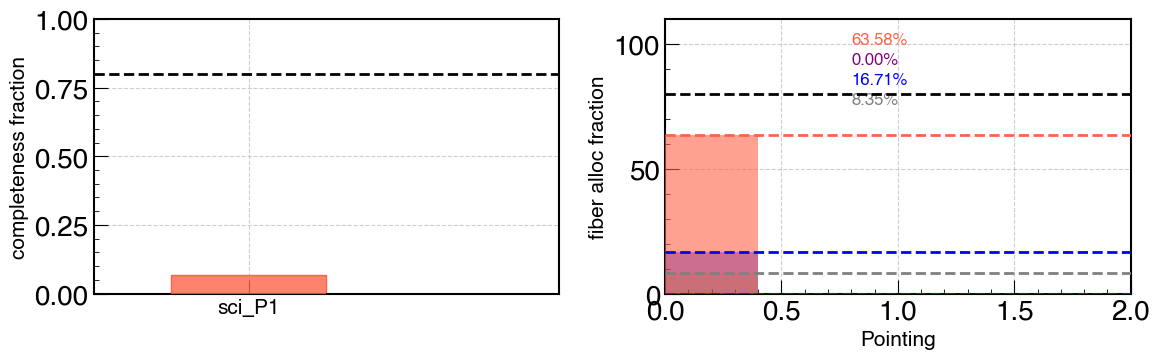

comp_out_tmp1 =  {'cal': 0.34305317324185247, 'sci_P1': 0.0683860531991373, 'sky': 0.008197897239358105}
1718.195299 secs passed after the visits done.


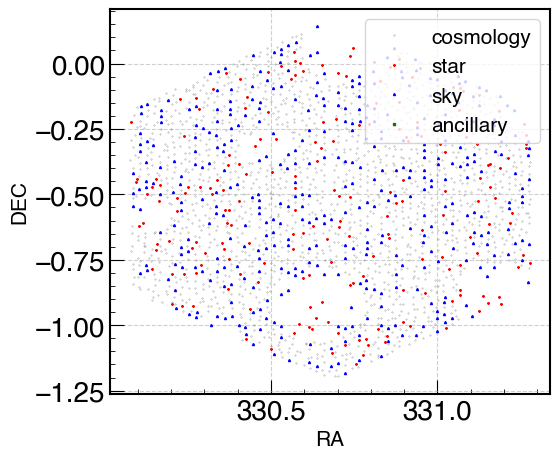

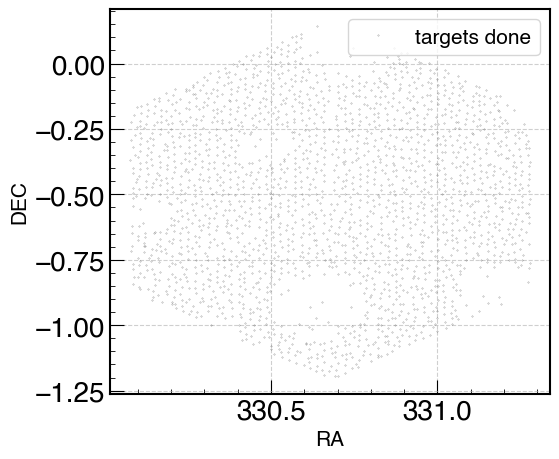

In [ ]:
'''
Comment: successfully tested for one pointing within 43 seconds
'''
bench, cobracoach = create_bench(layout="full")
collision_sim_version = 0
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

## calibration_ga + CollisionSimulator2

In [ ]:
'''
Comment: can not get results without trajectory collision even if I run the code for more than 10 minutes
---------------------------------------------------------------------------
ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
'''
bench, cobracoach = create_bench(layout="calibration_ga")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:55:50.429Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-13 12:55:50.509Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-13 12:55:50.526Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:55:50.529Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_005


Cobras with zero centers: 0
Cobras with zero link lengths: 0


2025-01-13 12:55:55.810Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:55:55.814Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:55:55.815Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:55:55.817Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-13 12:55:55.964Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-13 12:55:55.970Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-13 12:55:55.972Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-13 12:55:55.974Z root             20 DistortionCoefficients.py:715 Ra Dec 

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:56.633Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:56.635Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:56.646Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:56.649Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:56.650Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:06.674Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:06.676Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:06.679Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:06.680Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:06.682Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:06.687Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:06.689Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:06.698Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:06.701Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:06.705Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:06.707Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:06.712Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:06.724Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:06.736Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:06.774Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:07.515Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.71s


2025-01-13 12:56:07.517Z gurobipy         20 netflow.py:149 Presolve time: 0.71s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:07.524Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:07.534Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:07.537Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:07.551Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:07.554Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:07.557Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:07.564Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:07.568Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:07.570Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:07.578Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:07.590Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:07.596Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:07.683Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:07.686Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:07.689Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:07.694Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:07.699Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:07.702Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:07.705Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:07.708Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 12:56:07.713Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:07.717Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:07.720Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-13 12:56:07.723Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-13 12:56:07.727Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:07.730Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:07.734Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.19 seconds (0.00 work units)


2025-01-13 12:56:07.737Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.19 seconds (0.00 work units)


2025-01-13 12:56:07.773Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:07.775Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:07.779Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:07.781Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:07.784Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:07.801Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


2025-01-13 12:56:07.803Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:07.806Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:07.809Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:07.812Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:07.815Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:07.818Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:07.824Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:08.415Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:08.416Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.683Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.714Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.719Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:08.721Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:08.724Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:08.729Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:08.801Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:08.842Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:17.815Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:17.817Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:17.819Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:17.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:17.824Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:29.180Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:29.182Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:29.184Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:29.186Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:29.189Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:29.193Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:29.194Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:29.201Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:29.209Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:29.214Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:29.216Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:29.218Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:29.220Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:29.228Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:29.248Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:29.980Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 12:56:29.982Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:29.987Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:29.993Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:30.001Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:30.015Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:30.018Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:30.020Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:30.041Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:30.047Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:30.096Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:30.099Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:30.101Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:30.105Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:30.107Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:30.111Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:30.114Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:30.118Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:30.122Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:30.125Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:30.128Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:30.131Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 12:56:30.133Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:30.140Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:30.149Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:56:30.152Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:56:30.160Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:30.163Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:30.168Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 12:56:30.171Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 12:56:30.200Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:30.202Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:30.204Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:30.207Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:30.209Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:30.224Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 12:56:30.226Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:30.228Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:30.231Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:30.233Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:30.236Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:30.240Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:30.244Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:30.912Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:30.913Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.049Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.085Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.089Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:31.090Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:31.091Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:31.092Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:31.120Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:31.149Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:39.235Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:39.236Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:39.239Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:39.240Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:39.244Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:49.529Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:49.531Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:49.534Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:49.536Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:49.538Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:49.541Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:49.543Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:49.553Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:49.562Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:49.566Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:49.568Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:49.571Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:49.572Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:49.574Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:49.595Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:50.438Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 12:56:50.439Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:50.445Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:50.452Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:50.458Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:50.463Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:50.467Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:50.470Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:50.495Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:50.497Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:50.500Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:50.631Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:50.637Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:50.640Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:50.643Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:50.646Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:50.648Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:50.652Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:50.655Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:50.659Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:50.662Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:50.665Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


2025-01-13 12:56:50.667Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:50.670Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:50.673Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


2025-01-13 12:56:50.675Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


2025-01-13 12:56:50.678Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:50.680Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:50.685Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.22 seconds (0.00 work units)


2025-01-13 12:56:50.688Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.22 seconds (0.00 work units)


2025-01-13 12:56:50.712Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:50.715Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:50.718Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:50.721Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:50.775Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:50.811Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.27 seconds (0.35 work units)


2025-01-13 12:56:50.813Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.27 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:50.816Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:50.819Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:50.821Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:50.824Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:50.827Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:50.833Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:51.446Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:51.447Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.572Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.606Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.609Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:51.610Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:51.611Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:51.612Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:51.639Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:51.665Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:59.822Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:59.825Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:59.827Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:59.828Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:59.832Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:09.360Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:09.362Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:09.364Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:09.366Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:09.368Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:09.372Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:09.373Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:09.382Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:09.384Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:09.401Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:09.403Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:09.405Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:09.407Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:09.410Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:09.472Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:10.189Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 12:57:10.191Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:10.197Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:10.207Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:10.214Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:10.223Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:10.235Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:10.238Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:10.329Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:10.332Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:10.335Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:10.340Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:10.342Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:10.346Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:10.349Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:10.352Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:10.356Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:10.360Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:10.362Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:10.364Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:10.368Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:10.370Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 12:57:10.373Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:10.376Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:10.379Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.07s


2025-01-13 12:57:10.382Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.07s


2025-01-13 12:57:10.385Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:10.387Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:10.392Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.18 seconds (0.00 work units)


2025-01-13 12:57:10.396Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.18 seconds (0.00 work units)


2025-01-13 12:57:10.420Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:10.422Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:10.425Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:10.430Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:57:10.433Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:57:10.449Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.08 seconds (0.35 work units)


2025-01-13 12:57:10.451Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.08 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:10.453Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:10.456Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:10.459Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:10.461Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:10.464Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:10.468Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:11.238Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:11.239Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.372Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.409Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.412Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:11.414Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:11.415Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:11.415Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:11.446Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:11.472Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:57:19.438Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:57:19.440Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:57:19.441Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:57:19.443Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:57:19.444Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:30.756Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:30.758Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:30.760Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:30.762Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:30.764Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:30.768Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:30.771Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:30.778Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:30.780Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:30.784Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:30.786Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:30.789Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:30.791Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:30.793Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:30.816Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:31.485Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 12:57:31.487Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:31.493Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:31.498Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:31.501Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:31.509Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:31.512Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:31.514Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:31.520Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:31.524Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:31.526Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:31.529Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:31.531Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:31.534Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:31.538Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:31.540Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:31.543Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:31.545Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:31.549Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:31.550Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:31.552Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:31.556Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


2025-01-13 12:57:31.559Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:31.562Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:31.568Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:57:31.574Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:57:31.577Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:31.579Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:31.642Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.13 seconds (0.00 work units)


2025-01-13 12:57:31.662Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.13 seconds (0.00 work units)


2025-01-13 12:57:31.689Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:31.691Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:31.693Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:31.695Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:31.698Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:31.716Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 12:57:31.718Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:31.720Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:31.723Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:31.728Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:31.739Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:31.741Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:31.745Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:32.309Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:32.310Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.424Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.457Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.460Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:32.461Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:32.462Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:32.463Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:32.489Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:32.516Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:57:40.669Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:57:40.672Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:57:40.673Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:57:40.677Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:57:40.679Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:51.117Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:51.118Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:51.121Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:51.122Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:51.124Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:51.128Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:51.130Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:51.135Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:51.137Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:51.141Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:51.143Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:51.145Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:51.151Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:51.153Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:51.175Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:51.856Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 12:57:51.858Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:51.863Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:51.870Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:51.873Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:51.884Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:51.885Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:51.888Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:51.898Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:51.900Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:51.903Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:51.907Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:51.911Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:51.913Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:51.919Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:51.922Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:51.925Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:51.928Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:51.931Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:51.933Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:51.935Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:51.941Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 12:57:51.943Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:51.944Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:51.946Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:57:51.952Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:57:51.956Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:51.957Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:52.023Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:57:52.025Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:57:52.050Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:52.053Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:52.055Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:52.058Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:52.060Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:52.075Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 12:57:52.077Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:52.081Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:52.083Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:52.085Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:52.087Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:52.089Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:52.093Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:52.635Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:52.636Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.753Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.786Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.789Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:52.790Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:52.791Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:52.792Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:52.817Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:52.840Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:00.930Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:00.931Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:00.934Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:00.936Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:00.940Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:10.316Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:10.318Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:10.320Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:10.322Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:10.325Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:10.329Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:10.331Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:10.336Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:10.340Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:10.345Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:10.347Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:10.349Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:10.351Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:10.354Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:10.380Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:11.054Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 12:58:11.055Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:11.062Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:11.068Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:11.071Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:11.076Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:11.080Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:11.082Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:11.086Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:11.088Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:11.092Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:11.094Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:11.100Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:11.103Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:11.105Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:11.106Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:11.108Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:11.112Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:11.114Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:11.118Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:11.121Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:11.124Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 12:58:11.128Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:11.130Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:11.132Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:58:11.133Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:58:11.135Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:11.138Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:11.144Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:58:11.145Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:58:11.155Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:11.159Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:11.161Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:11.162Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:58:11.167Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:58:11.183Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


2025-01-13 12:58:11.185Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:11.245Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:11.255Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:11.263Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:11.267Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:11.270Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:11.276Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:11.765Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:11.766Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.880Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.912Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.915Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:11.916Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:11.917Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:11.918Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:11.943Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:11.966Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:19.918Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:19.919Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:19.923Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:19.925Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:19.927Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:31.720Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:31.723Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:31.725Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:31.728Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:31.730Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:31.737Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:31.739Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:31.752Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:31.756Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:31.764Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:31.766Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:31.778Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:31.779Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:31.785Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:31.826Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:32.706Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.85s


2025-01-13 12:58:32.708Z gurobipy         20 netflow.py:149 Presolve time: 0.85s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:32.714Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:32.721Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:32.725Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:32.737Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:32.739Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:32.741Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:32.747Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:32.748Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:32.750Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:32.753Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:32.784Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:32.831Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:32.835Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:32.837Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:32.840Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:32.842Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:32.844Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:32.846Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:32.849Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:32.852Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


2025-01-13 12:58:32.854Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:32.857Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:32.859Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:58:32.862Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:58:32.864Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:32.867Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:32.875Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:58:32.878Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:58:32.905Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:32.908Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:32.909Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:32.910Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:32.912Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:32.927Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.19 seconds (0.35 work units)


2025-01-13 12:58:32.928Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.19 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:32.930Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:32.932Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:32.936Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:32.938Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:32.940Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:32.945Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:33.495Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:33.496Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.620Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.655Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.658Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:33.659Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:33.660Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:33.661Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:33.692Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:33.717Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:42.259Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:42.261Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:42.263Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:42.266Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:42.269Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:53.114Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:53.115Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:53.118Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:53.119Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:53.121Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:53.125Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:53.127Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:53.132Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:53.133Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:53.138Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:53.139Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:53.140Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:53.143Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:53.145Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:53.224Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:54.163Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.91s


2025-01-13 12:58:54.165Z gurobipy         20 netflow.py:149 Presolve time: 0.91s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:54.172Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:54.178Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:54.182Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:54.187Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:54.189Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:54.191Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:54.198Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:54.200Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:54.202Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:54.204Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:54.205Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:54.208Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:54.210Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:54.216Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:54.217Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:54.226Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:54.229Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:54.231Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:54.235Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:54.238Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


2025-01-13 12:58:54.240Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:54.242Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:54.251Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:58:54.253Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:58:54.255Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:54.267Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:54.280Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-13 12:58:54.284Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-13 12:58:54.293Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:54.295Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:54.298Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:54.301Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:54.304Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:54.322Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


2025-01-13 12:58:54.324Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:54.333Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:54.338Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:54.341Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:54.343Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:54.348Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:54.357Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:55.021Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:55.022Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.160Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.196Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.199Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:55.201Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:55.201Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:55.202Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:55.227Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:55.253Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:59:03.936Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:59:03.939Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:59:03.943Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:59:03.946Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:59:03.948Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:15.438Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:15.441Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:59:15.444Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:15.446Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:15.448Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:59:15.452Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:59:15.454Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:59:15.461Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:59:15.466Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:59:15.473Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:59:15.475Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:59:15.477Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:59:15.478Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:59:15.480Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:59:15.505Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:59:16.321Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.78s


2025-01-13 12:59:16.323Z gurobipy         20 netflow.py:149 Presolve time: 0.78s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:59:16.330Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:59:16.336Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:59:16.340Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:59:16.346Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:59:16.347Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:59:16.348Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:59:16.353Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:59:16.355Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:59:16.359Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:59:16.362Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:59:16.364Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:59:16.365Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:59:16.369Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:59:16.372Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:59:16.374Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:59:16.377Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:59:16.378Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:59:16.379Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:16.384Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:16.386Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 12:59:16.387Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:16.389Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:16.396Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 12:59:16.398Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 12:59:16.400Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:59:16.401Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:59:16.411Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:16.413Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:16.418Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:59:16.427Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:16.437Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:16.439Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:16.441Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:16.469Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 12:59:16.470Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:59:16.472Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:59:16.476Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:16.479Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:16.481Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:59:16.483Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:59:16.495Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:59:17.198Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:59:17.199Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.331Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.368Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.372Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:59:17.373Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:59:17.374Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:59:17.374Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:59:17.405Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:59:17.429Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:59:25.440Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:59:25.441Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:59:25.444Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:59:25.447Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:59:25.450Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:35.362Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:35.364Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:59:35.370Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:35.372Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:35.373Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:59:35.378Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:59:35.380Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:59:35.386Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:59:35.388Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:59:35.404Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:59:35.405Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:59:35.407Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:59:35.409Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:59:35.412Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:59:35.443Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:59:36.331Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.77s


2025-01-13 12:59:36.332Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:59:36.339Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:59:36.346Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:59:36.349Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:59:36.353Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:59:36.356Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:59:36.357Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:59:36.361Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:59:36.363Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:59:36.365Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:59:36.370Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:59:36.372Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:59:36.373Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:59:36.378Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:59:36.380Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:59:36.382Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:59:36.385Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:59:36.393Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:59:36.395Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:36.396Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:36.398Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 12:59:36.399Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:36.405Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:36.408Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:59:36.411Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:59:36.414Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:59:36.420Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:59:36.424Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:36.426Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:36.442Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:59:36.444Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:36.450Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:36.594Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:59:36.598Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:59:36.614Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.24 seconds (0.35 work units)


2025-01-13 12:59:36.616Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.24 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:59:36.618Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:59:36.620Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:36.622Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:36.624Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:59:36.626Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:59:36.630Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:59:37.277Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:59:37.279Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.397Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.431Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.436Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:59:37.437Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:59:37.438Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:59:37.439Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:59:37.463Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:59:37.490Z pfi              40 pfi.py:899 Some

## calibration_cobrascalibrationproduct + CollisionSimulator2

In [32]:
'''
Comment: Can not get a solution without trajectory collision, even if I run the code for a long time
---------------------------------------------------------------------------
ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
'''
bench, cobracoach = create_bench(layout="calibration_cobrascalibrationproduct")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:43:05.479Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-13 12:43:05.570Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-13 12:43:05.582Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:43:05.585Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_001
/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobrasCalibrationProduct.py:163: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobrasCalibrationProduct.py:165: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slo

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:43:13.765Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:43:13.769Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:43:13.774Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:43:13.778Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:43:13.780Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:14.947Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:14.949Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:43:14.951Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:14.954Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:14.955Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:43:14.960Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1086 rows, 651 columns and 2359 nonzeros


2025-01-13 12:43:14.964Z gurobipy         20 netflow.py:149 Optimize a model with 1086 rows, 651 columns and 2359 nonzeros


Model fingerprint: 0x58794a07


2025-01-13 12:43:14.978Z gurobipy         20 netflow.py:149 Model fingerprint: 0x58794a07


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:43:14.980Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:43:14.982Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:43:14.983Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:43:14.988Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:43:14.991Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:43:14.995Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:43:15.093Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1086 rows and 651 columns


2025-01-13 12:43:15.098Z gurobipy         20 netflow.py:149 Presolve removed 1086 rows and 651 columns


Presolve time: 0.00s


2025-01-13 12:43:15.102Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:43:15.105Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:43:15.107Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


2025-01-13 12:43:15.110Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:43:15.113Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:43:15.115Z gurobipy         20 netflow.py:149 


Solution count 2: 4.02002e+08 6e+08 


2025-01-13 12:43:15.118Z gurobipy         20 netflow.py:149 Solution count 2: 4.02002e+08 6e+08 


2025-01-13 12:43:15.121Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:43:15.123Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.020023536960e+08, best bound 4.020023536960e+08, gap 0.0000%


2025-01-13 12:43:15.127Z gurobipy         20 netflow.py:149 Best objective 4.020023536960e+08, best bound 4.020023536960e+08, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:43:28.186Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:43:28.191Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.438Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.469Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:43:28.470Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:43:28.471Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:43:28.472Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:43:28.507Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:43:28.536Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 40
Set parameter Presolve to value 1


2025-01-13 12:43:38.661Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:43:38.665Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:43:38.667Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:43:38.670Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:43:38.672Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:39.983Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:39.984Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:43:39.987Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:39.988Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:39.991Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:43:39.995Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1251 rows, 651 columns and 2745 nonzeros


2025-01-13 12:43:39.996Z gurobipy         20 netflow.py:149 Optimize a model with 1251 rows, 651 columns and 2745 nonzeros


Model fingerprint: 0xa30b7baa


2025-01-13 12:43:40.002Z gurobipy         20 netflow.py:149 Model fingerprint: 0xa30b7baa


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:43:40.026Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:43:40.029Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:43:40.032Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:43:40.038Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:43:40.040Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:43:40.058Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:43:40.067Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 635 columns


2025-01-13 12:43:40.107Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 635 columns


Presolve time: 0.01s


2025-01-13 12:43:40.112Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 13 rows, 16 columns, 46 nonzeros


2025-01-13 12:43:40.136Z gurobipy         20 netflow.py:149 Presolved: 13 rows, 16 columns, 46 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:43:40.139Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 16 integer (16 binary)


2025-01-13 12:43:40.143Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 16 integer (16 binary)


2025-01-13 12:43:40.169Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.00 work units)


2025-01-13 12:43:40.172Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:43:40.176Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:43:40.180Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:43:40.183Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:43:40.188Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:43:40.191Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021256927e+08, best bound 4.130022096770e+08, gap 2.3640%


2025-01-13 12:43:40.193Z gurobipy         20 netflow.py:149 Best objective 4.230021256927e+08, best bound 4.130022096770e+08, gap 2.3640%


Checking for trajectory collisions


2025-01-13 12:43:54.313Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:43:54.314Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.433Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.491Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.495Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:43:54.497Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:43:54.498Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:43:54.500Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:43:54.528Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:43:54.551Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 8
Set parameter Presolve to value 1


2025-01-13 12:44:02.649Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:02.650Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:02.653Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:02.655Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:02.657Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:03.853Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:03.854Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:03.857Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:03.862Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:03.865Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:03.870Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:03.873Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:03.903Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:03.906Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:03.908Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:03.909Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:03.911Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:03.916Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:03.917Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:03.919Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:03.928Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:44:03.934Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:03.936Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:03.946Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:03.948Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:03.950Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


2025-01-13 12:44:03.954Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:03.978Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:03.987Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:03.989Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:04.007Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:04.013Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:04.016Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:44:17.129Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:44:17.130Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.258Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.293Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.296Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:44:17.297Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:44:17.297Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:44:17.301Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:44:17.328Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:44:17.354Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:44:25.484Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:25.486Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:25.489Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:25.491Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:25.493Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:26.649Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:26.651Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:26.653Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:26.655Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:26.658Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:26.661Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:26.663Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:26.668Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:26.674Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:26.677Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:26.679Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:26.681Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:26.683Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:26.685Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:26.691Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:26.789Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:44:26.794Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:26.796Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:26.798Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:26.801Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:26.805Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


2025-01-13 12:44:26.809Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:26.811Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:26.814Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:26.816Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:26.818Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:26.821Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:26.823Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:44:39.831Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:44:39.832Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:39.965Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:40.001Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:40.004Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:44:40.005Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:44:40.006Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:44:40.007Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:44:40.186Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:44:40.209Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:44:48.053Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:48.055Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:48.058Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:48.060Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:48.061Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:49.202Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:49.204Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:49.206Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:49.208Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:49.210Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:49.213Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:49.216Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:49.220Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:49.223Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:49.224Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:49.237Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:49.253Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:49.256Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:49.258Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:49.260Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:49.281Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:44:49.294Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:49.296Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:49.299Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:49.301Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:49.302Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)


2025-01-13 12:44:49.304Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:49.308Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:49.422Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:49.424Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:49.426Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:49.429Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:49.431Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:02.686Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:02.687Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.814Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.848Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.851Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:02.852Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:02.853Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:02.854Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:02.883Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:02.908Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:11.099Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:11.100Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:11.103Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:11.105Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:11.107Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:12.275Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:12.278Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:12.280Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:12.283Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:12.285Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:12.288Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:12.290Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:12.301Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:12.303Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:12.320Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:12.323Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:12.326Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:12.331Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:12.336Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:12.360Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:12.370Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:45:12.372Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:12.398Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:12.401Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:12.403Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:12.407Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.00 work units)


2025-01-13 12:45:12.410Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:12.424Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:12.426Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:12.496Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:12.504Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:12.506Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:12.508Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:25.647Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:25.648Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.767Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.805Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.809Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:25.810Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:25.811Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:25.811Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:25.839Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:25.863Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:33.745Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:33.746Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:33.749Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:33.751Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:33.753Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:34.939Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:34.943Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:34.945Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:34.947Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:34.949Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:34.954Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:34.955Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:35.114Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:35.116Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:35.119Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:35.124Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:35.130Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:35.133Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:35.142Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:35.146Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:35.154Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:45:35.158Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:35.161Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:35.165Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:35.169Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:35.173Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.00 work units)


2025-01-13 12:45:35.176Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:35.177Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:35.179Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:35.182Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:35.184Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:35.187Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:35.190Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:48.301Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:48.302Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.425Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.462Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.467Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:48.468Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:48.469Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:48.472Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:48.498Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:48.525Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:56.527Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:56.528Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:56.531Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:56.533Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:56.536Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:57.717Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:57.721Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:57.722Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:57.724Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:57.725Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:57.730Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:57.732Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:57.734Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:57.741Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:57.744Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:57.762Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:57.788Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:57.791Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:57.794Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:57.798Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:57.806Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:45:57.808Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:57.813Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:57.887Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:57.890Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:57.892Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.00 work units)


2025-01-13 12:45:57.894Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:57.896Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:57.898Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:57.900Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:57.902Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:57.905Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:57.907Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:11.513Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:11.514Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.631Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.665Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.668Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:11.669Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:11.670Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:11.671Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:11.697Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:11.721Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:46:19.789Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:46:19.790Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:46:19.793Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:46:19.794Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:46:19.798Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:20.960Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:20.962Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:46:20.965Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:20.968Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:20.970Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:46:20.973Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:46:20.975Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:46:20.976Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:46:20.979Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:46:20.980Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:46:20.982Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:46:20.985Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:46:20.986Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:46:20.988Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:46:20.992Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:46:21.005Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:46:21.007Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:46:21.009Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:46:21.011Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:21.094Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:21.109Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


2025-01-13 12:46:21.111Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:46:21.114Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:46:21.118Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:21.120Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:21.126Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:46:21.133Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:46:21.135Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:33.998Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:33.999Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.114Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.148Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.151Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:34.152Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:34.153Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:34.154Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:34.180Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:34.202Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:46:41.972Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:46:41.975Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:46:41.979Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:46:41.981Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:46:41.983Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:43.091Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:43.093Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:46:43.095Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:43.097Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:43.099Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:46:43.102Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:46:43.104Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:46:43.105Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:46:43.107Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:46:43.112Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:46:43.113Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:46:43.115Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:46:43.118Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:46:43.119Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:46:43.121Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:46:43.132Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:46:43.134Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:46:43.139Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:46:43.147Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:43.149Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:43.151Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:46:43.152Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:46:43.153Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:46:43.158Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:43.162Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:43.164Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:46:43.166Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:46:43.170Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:56.725Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:56.726Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.837Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.869Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.872Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:56.873Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:56.874Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:56.875Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:56.901Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:56.924Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:04.874Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:04.875Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:04.878Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:04.879Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:04.882Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:06.014Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:06.015Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:06.017Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:06.022Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:06.023Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:06.026Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:06.029Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:06.030Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:06.032Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:06.033Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:06.038Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:06.039Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:06.041Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:06.044Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:06.046Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:06.056Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:47:06.060Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:06.062Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:06.063Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:06.065Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:06.067Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:47:06.068Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:06.070Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:06.073Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:06.077Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:06.078Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:06.081Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:06.083Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:47:18.915Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:47:18.917Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.144Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.189Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.194Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:47:19.196Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:47:19.197Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:47:19.198Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:47:19.230Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:47:19.258Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:27.190Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:27.192Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:27.194Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:27.196Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:27.200Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:28.266Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:28.268Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:28.270Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:28.273Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:28.274Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:28.277Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:28.279Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:28.280Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:28.282Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:28.284Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:28.287Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:28.289Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:28.300Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:28.302Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:28.306Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:28.311Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:47:28.314Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:28.317Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:28.319Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:28.322Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:28.323Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:47:28.325Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:28.327Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:28.330Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:28.335Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:28.337Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:28.338Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:28.339Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:47:41.525Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:47:41.527Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.649Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.685Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.689Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:47:41.690Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:47:41.691Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:47:41.692Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:47:41.719Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:47:41.745Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:49.815Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:49.817Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:49.818Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:49.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:49.824Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:50.928Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:50.930Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:50.932Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:50.935Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:50.936Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:50.941Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:50.944Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:50.945Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:50.947Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:50.948Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:50.951Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:50.954Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:50.956Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:50.957Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:50.959Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:50.967Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:47:50.969Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:50.975Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:50.980Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:50.984Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:50.986Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:47:50.987Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:50.988Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:50.991Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:50.996Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:50.997Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:51.000Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:51.001Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:05.607Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:05.608Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.724Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.757Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.760Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:05.761Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:05.762Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:05.763Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:05.788Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:05.810Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:13.937Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:13.939Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:13.941Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:13.943Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:13.946Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:15.044Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:15.046Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:48:15.048Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:15.050Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:15.052Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:48:15.058Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:48:15.060Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:48:15.061Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:48:15.063Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:48:15.064Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:48:15.066Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:48:15.067Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:48:15.068Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:48:15.069Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:48:15.076Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:48:15.082Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:48:15.084Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:48:15.087Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:48:15.093Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:15.095Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:15.098Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:48:15.099Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:48:15.100Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:48:15.102Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:15.104Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:15.106Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:48:15.109Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:48:15.111Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:28.322Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:28.323Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.434Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.470Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:28.471Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:28.472Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:28.473Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:28.498Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:28.521Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:36.391Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:36.392Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:36.395Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:36.397Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:36.401Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:37.540Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:37.542Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:48:37.545Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:37.546Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:37.548Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:48:37.553Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:48:37.554Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:48:37.556Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:48:37.557Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:48:37.558Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:48:37.560Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:48:37.562Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:48:37.564Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:48:37.571Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:48:37.574Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:48:37.584Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:48:37.586Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:48:37.588Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:48:37.589Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:37.591Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:37.594Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:48:37.597Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:48:37.599Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:48:37.604Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:37.606Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:37.608Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:48:37.609Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:48:37.613Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:51.437Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:51.438Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.548Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.582Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.585Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:51.586Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:51.586Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:51.587Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:51.612Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:51.634Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:59.564Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:59.566Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:59.568Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:59.571Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:59.573Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:00.709Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:00.712Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:00.714Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:00.716Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:00.719Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:00.724Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:00.726Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:00.728Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:00.730Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:00.739Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:00.742Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:00.744Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:00.751Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:00.757Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:00.769Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:00.775Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:49:00.777Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:00.791Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:00.795Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:00.802Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:00.804Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


2025-01-13 12:49:00.806Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:00.809Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:00.825Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:00.826Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:00.828Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:00.840Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:00.842Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:49:15.263Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:49:15.264Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.391Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.426Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.428Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:49:15.429Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:49:15.430Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:49:15.433Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:49:15.460Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:49:15.483Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:49:23.814Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:49:23.816Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:49:23.819Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:49:23.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:49:23.829Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:25.020Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:25.022Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:25.025Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:25.029Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:25.031Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:25.036Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:25.037Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:25.038Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:25.041Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:25.042Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:25.044Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:25.049Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:25.051Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:25.053Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:25.056Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:25.068Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:49:25.070Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:25.075Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:25.078Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:25.080Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:25.081Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:49:25.082Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:25.084Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:25.091Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:25.098Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:25.102Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:25.105Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:25.106Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:49:38.587Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:49:38.588Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.711Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.746Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.749Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:49:38.750Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:49:38.752Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:49:38.753Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:49:38.778Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:49:38.804Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:49:46.785Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:49:46.787Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:49:46.790Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:49:46.792Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:49:46.794Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:47.929Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:47.930Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:47.933Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:47.935Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:47.938Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:47.942Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:47.944Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:47.945Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:47.946Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:47.948Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:47.949Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:47.950Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:47.953Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:47.954Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:47.956Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:47.963Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:49:47.964Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:47.966Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:47.967Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:47.969Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:47.974Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


2025-01-13 12:49:47.977Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:47.979Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:47.980Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:47.984Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:47.986Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:47.989Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:47.992Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:01.668Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:01.669Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.790Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.828Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.833Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:01.834Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:01.836Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:01.837Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:01.868Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:01.894Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:10.343Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:10.344Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:10.347Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:10.351Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:10.353Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:11.675Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:11.677Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:11.680Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:11.684Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:11.686Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:11.691Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:11.695Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:11.697Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:11.699Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:11.701Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:11.706Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:11.708Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:11.711Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:11.720Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:11.734Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:11.762Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:50:11.764Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:11.770Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:11.773Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:11.775Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:11.800Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.00 work units)


2025-01-13 12:50:11.804Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:11.807Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:11.809Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:11.815Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:11.818Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:11.821Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:11.828Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:25.363Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:25.364Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.486Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.519Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.521Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:25.524Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:25.525Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:25.526Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:25.550Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:25.573Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:33.456Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:33.458Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:33.461Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:33.464Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:33.466Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:34.645Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:34.648Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:34.650Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:34.652Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:34.654Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:34.658Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:34.659Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:34.664Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:34.666Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:34.667Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:34.670Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:34.672Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:34.673Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:34.677Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:34.682Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:34.688Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:50:34.689Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:34.694Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:34.702Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:34.710Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:34.716Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


2025-01-13 12:50:34.718Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:34.727Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:34.737Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:34.739Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:34.741Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:34.749Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:34.752Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:48.678Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:48.679Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.806Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.842Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.845Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:48.846Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:48.847Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:48.847Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:48.874Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:48.897Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:57.153Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:57.155Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:57.158Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:57.160Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:57.162Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:56.764Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:56.768Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:56.786Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:56.791Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:56.794Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:56.799Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:56.802Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:56.804Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:56.806Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:56.812Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:56.818Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:56.822Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:56.824Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:56.829Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:56.835Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:56.844Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:50:56.846Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:56.849Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:56.852Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:56.854Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:56.855Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


2025-01-13 12:50:56.857Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:56.858Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:56.860Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:56.862Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:56.863Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:56.867Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:56.869Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:51:11.970Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:51:11.971Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.103Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.136Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.139Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:51:12.142Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:51:12.142Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:51:12.143Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:51:12.168Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:51:12.192Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:51:21.424Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:51:21.425Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:51:21.428Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:51:21.431Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:51:21.433Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:22.790Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:22.792Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:51:22.794Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:22.796Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:22.799Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:51:22.803Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:51:22.805Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:51:22.806Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:51:22.808Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:51:22.809Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:51:22.810Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:51:22.811Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:51:22.818Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:51:22.820Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:51:22.821Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:51:22.833Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:51:22.834Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:51:22.836Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:51:22.838Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:22.839Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:22.840Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:51:22.850Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:51:22.854Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:51:22.856Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:22.858Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:22.866Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:51:22.870Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:51:22.872Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:51:37.780Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:51:37.781Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.932Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.968Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.971Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:51:37.973Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:51:37.974Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:51:37.975Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:51:38.005Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:51:38.034Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:51:46.714Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:51:46.715Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:51:46.718Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:51:46.720Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:51:46.722Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:47.822Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:47.824Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:51:47.827Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:47.829Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:47.831Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:51:47.836Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:51:47.838Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:51:47.839Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:51:47.840Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:51:47.842Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:51:47.843Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:51:47.844Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:51:47.846Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:51:47.849Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:51:47.851Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:51:47.856Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:51:47.861Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:51:47.864Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:51:47.866Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:47.867Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:47.869Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


2025-01-13 12:51:47.884Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:51:47.886Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:51:47.889Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:47.894Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:47.895Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:51:47.896Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:51:47.898Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:52:02.610Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:52:02.611Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.740Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.775Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.778Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:52:02.779Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:52:02.780Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:52:02.781Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:52:02.808Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:52:02.831Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:52:11.459Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:52:11.460Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:52:11.463Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:52:11.467Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:52:11.472Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities


KeyboardInterrupt: 

## calibration_pfi_module + CollisionSimulator2

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:55:11.660Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [799, 853, 949, 1653, 1724]
2025-01-13 12:55:11.738Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 193, 347, 361, 754, 799, 821, 853, 949, 1150, 1208, 1210, 1520, 1580, 1637, 1653, 1724, 1825, 1836, 1882, 1903, 2053, 2352, 2380]
2025-01-13 12:55:11.749Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:55:11.752Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_004
2025-01-13 12:55:17.427Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:55:17.430Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:55:17.432Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:55:17.435Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"


solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:18.123Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:18.124Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:18.127Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:18.129Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:18.131Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:19.083Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:19.086Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:55:19.089Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:19.092Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:19.093Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:55:19.098Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 2 rows, 3 columns and 2 nonzeros


2025-01-13 12:55:19.104Z gurobipy         20 netflow.py:149 Optimize a model with 2 rows, 3 columns and 2 nonzeros


Model fingerprint: 0x0e10d7f3


2025-01-13 12:55:19.106Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0e10d7f3


Variable types: 1 continuous, 2 integer (0 binary)


2025-01-13 12:55:19.108Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 2 integer (0 binary)


Coefficient statistics:


2025-01-13 12:55:19.109Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:55:19.110Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+06]


2025-01-13 12:55:19.112Z gurobipy         20 netflow.py:149   Objective range  [1e+00, 1e+06]


  Bounds range     [0e+00, 0e+00]


2025-01-13 12:55:19.117Z gurobipy         20 netflow.py:149   Bounds range     [0e+00, 0e+00]


  RHS range        [2e+02, 4e+02]


2025-01-13 12:55:19.122Z gurobipy         20 netflow.py:149   RHS range        [2e+02, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:55:19.221Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 2 rows and 3 columns


2025-01-13 12:55:19.223Z gurobipy         20 netflow.py:149 Presolve removed 2 rows and 3 columns


Presolve time: 0.00s


2025-01-13 12:55:19.225Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:55:19.243Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:55:19.246Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


2025-01-13 12:55:19.250Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:55:19.253Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:55:19.256Z gurobipy         20 netflow.py:149 


Solution count 1: 6e+08 


2025-01-13 12:55:19.260Z gurobipy         20 netflow.py:149 Solution count 1: 6e+08 


2025-01-13 12:55:19.263Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:55:19.266Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


2025-01-13 12:55:19.270Z gurobipy         20 netflow.py:149 Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


Checking for trajectory collisions


/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobraGroup.py:193: RuntimeWarning: invalid value encountered in divide
  -(L2Sq - L1Sq - distanceSq) / (2 * L1 * distance))
2025-01-13 12:55:20.125Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.126Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.311Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.312Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.338Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.339Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.342Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:55:20.343Z engineer         20 engineer.py:396 Move phi arms to angle=[11.13 24.06 13.16 ...  8.78 11.66  8.5 ] degree
2025-01-13

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:22.683Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:22.685Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:22.688Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:22.691Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:22.693Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:23.645Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:23.647Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:55:23.649Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:23.650Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:23.653Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:55:23.659Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 2 rows, 3 columns and 2 nonzeros


2025-01-13 12:55:23.662Z gurobipy         20 netflow.py:149 Optimize a model with 2 rows, 3 columns and 2 nonzeros


Model fingerprint: 0x0e10d7f3


2025-01-13 12:55:23.665Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0e10d7f3


Variable types: 1 continuous, 2 integer (0 binary)


2025-01-13 12:55:23.666Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 2 integer (0 binary)


Coefficient statistics:


2025-01-13 12:55:23.669Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:55:23.676Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+06]


2025-01-13 12:55:23.680Z gurobipy         20 netflow.py:149   Objective range  [1e+00, 1e+06]


  Bounds range     [0e+00, 0e+00]


2025-01-13 12:55:23.683Z gurobipy         20 netflow.py:149   Bounds range     [0e+00, 0e+00]


  RHS range        [2e+02, 4e+02]


2025-01-13 12:55:23.685Z gurobipy         20 netflow.py:149   RHS range        [2e+02, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:55:23.686Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 2 rows and 3 columns


2025-01-13 12:55:23.690Z gurobipy         20 netflow.py:149 Presolve removed 2 rows and 3 columns


Presolve time: 0.00s


2025-01-13 12:55:23.696Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:55:23.699Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:55:23.702Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:55:23.708Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:55:23.711Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:55:23.718Z gurobipy         20 netflow.py:149 


Solution count 1: 6e+08 


2025-01-13 12:55:23.721Z gurobipy         20 netflow.py:149 Solution count 1: 6e+08 


2025-01-13 12:55:23.724Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:55:23.728Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


2025-01-13 12:55:23.731Z gurobipy         20 netflow.py:149 Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:55:24.755Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.756Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.872Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.873Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.897Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.897Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.900Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:55:24.901Z engineer         20 engineer.py:396 Move phi arms to angle=[11.13 24.06 13.16 ...  8.78 11.66  8.5 ] degree
2025-01-13 12:55:24.902Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:55:24.905Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
objVal0 = 600000000.000000, objVal1=600000000.000000
exposure 0:
  assigned Cobras: 0
exposure 0:
assigned Cobras(%): 0.00%; gal--0.00%, anc--0.00%, sky--0.00%, star--0.00%
comp_out= {'cal': 0.0, 'sci_P1': 0.0, 'sky': 0.0}
['sci_P1']


/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2653813083.py:412: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_ii = tgt_class_allo == uniq_tgt_i


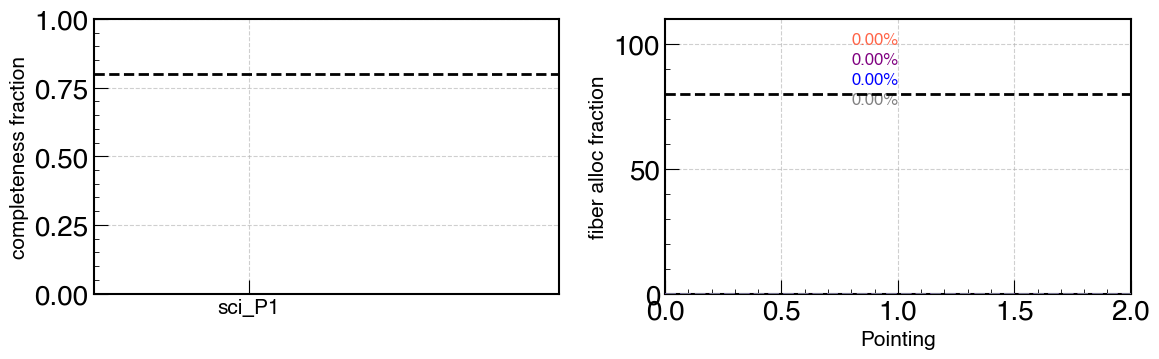

comp_out_tmp1 =  {'cal': 0.0, 'sci_P1': 0.0, 'sky': 0.0}
3070.478513 secs passed after the visits done.


/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/79039579.py:38: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2123539643.py:7: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')


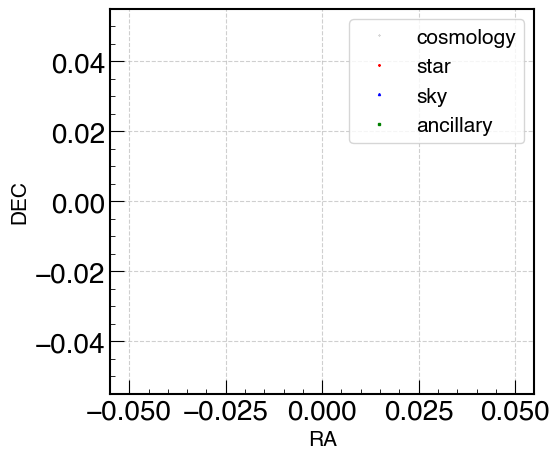

/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2123539643.py:7: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')


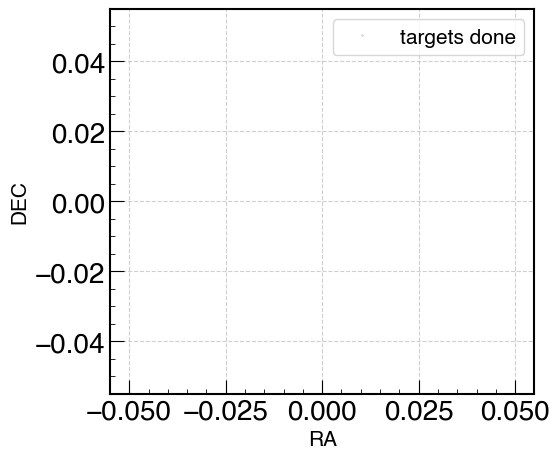

In [36]:
'''
Comment: no targets are assigned to the fibers
'''
bench, cobracoach = create_bench(layout="calibration_pfi_module")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

In [10]:
#tclassdict = {'sci_P1' : 1, 'sky' : 2, 'cal' : 3}
#write_pfsDesign(outdir, 'pfsDesign_region3_3h_v1.txt', res, tpos, telescopes, tgt, classdict)

# TO-DO Lists
+ fix the problem of gurobi.lic in py_env_co_fa
+ update the target list after each observation
+ second visit, pointing center shift to avoid vignetting 
+ longer exposure option for second visit
+ (DONE!) remove the calibration targets in AlreadyObserved dict

+ (DONE!) CollisionSimulator versus SollisionSimulator2? 
+ cobra home position and collision simulator? 
+ generate 1h pfsDesign file using the code block above (CO will use first 6-8 hours)
+ (DONE!) (Q: iPS1 mag>18 is ok?) apply magnitude cut on bright stars
>>> Wanqiu: fainter than 16 (18 might be safer choice according to Andy)
+ (DONE) increase the sky/star fibers
>>> Masayuki - FLUXSTDs: 100-200 stars are good. Please distribute these stars uniformly across the field. 

+ fiberStatus? -- bad fibers and bad Cobra
+ apply bright star mask to sky/stars
+ generate uniform sky/star fiber assignment 
>>> Masato Onodera - I don't think I can put my script to check the uniformity of the distributions of sky and fluxstd objects against the home positions of science fibers. Please see the following gist how it's made. It uses dcor package for the comparsion, so making your own should be simple.
For the GA Fornax design, there is no configuration with p<0.05 (if my calculation is right).
https://gist.github.com/monodera/4c6fef2ce6a8370338250cd78ac78f26

>>> refer GA group code -
https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/nb/examples/netflow/8_cobra_groups.ipynb



# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)

